# Marginal 1-dim posteriors from image data

- Using SWYFT core functions
- Demonstrates `head` network

Author: Christoph Weniger, July 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [42]:
DEVICE = 'cuda:0'
NDIM = 5 # number of parameters
NTRAIN = 3000 # training steps
NBATCH = 64  # minibatch size
NSAMPLES = 3000 # traing batch size

In [43]:
# A toy model with a diffuse and point source component

def model(z, sigma = .1):
    z = z.numpy()
    x = np.linspace(-5, 5, 50, 50)
    X, Y = np.meshgrid(x,x)
    diff = np.cos(X+z[1]*2)*np.cos(Y+z[2]*2)*z[0]
    p = np.random.randn(*X.shape)*z[4]-0.3
    psc = 10**p*z[3]
    n = np.random.randn(*X.shape)*sigma
    out = (diff*5 + psc + n)
    return torch.tensor(out).float()

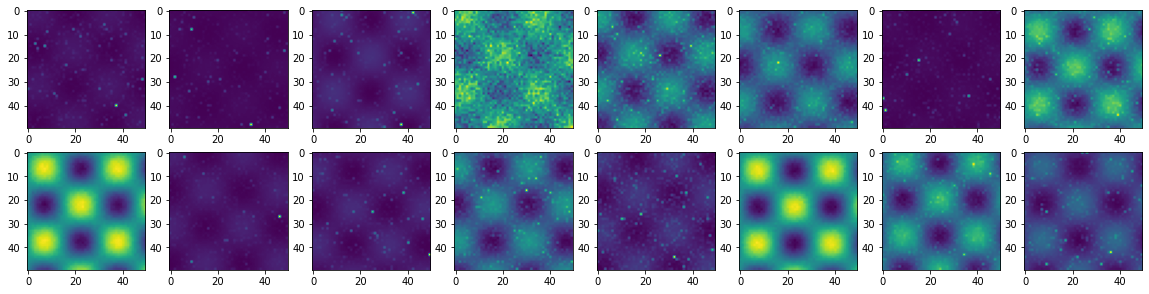

In [44]:
# Random image realizations

plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 8, i+1)
    z0 = torch.rand(5)
    x0 = model(z0)
    plt.imshow(x0.numpy())

In [45]:
# Generate training data
z_cpu = swyft.sample_hypercube(NSAMPLES, NDIM)
xz_cpu = swyft.simulate_xz(model, z_cpu)

100%|██████████| 300/300 [00:00<00:00, 913.11it/s]


In [46]:
# Move training data to GPU
xz = []
for entry in tqdm(xz_cpu):
    ex = entry['x'].to(DEVICE)
    ez = entry['z'].to(DEVICE)
    xz.append(dict(x = ex, z = ez))
z = swyft.get_z(xz)

100%|██████████| 300/300 [00:00<00:00, 14391.49it/s]


In [47]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [48]:
# Get number of features by evaluating Head network once on target data

ydim = Head()(x0.unsqueeze(0)).shape[1]  # Number of output features per image
print("Number of features:", ydim)

Number of features: 160


In [49]:
# Instantiate network

net = swyft.Network(xdim = ydim, zdim = NDIM, head = Head().cuda()).to(DEVICE).train()

In [50]:
# Train!

loss  = swyft.train(net, xz, n_train = NTRAIN, lr = 1e-3, n_batch = NBATCH)
loss += swyft.train(net, xz, n_train = NTRAIN, lr = 1e-4, n_batch = NBATCH)
loss += swyft.train(net, xz, n_train = NTRAIN, lr = 1e-5, n_batch = NBATCH)

100%|██████████| 1000/1000 [00:26<00:00, 37.93it/s]


estimating lnL: 100%|██████████| 5/5 [00:00<00:00, 264.59it/s]


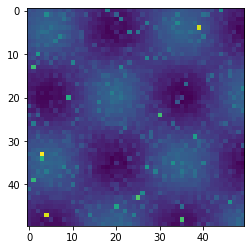

In [66]:
# Generate test image for given parameters, estimate posteriors

z0 = torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5])
x0 = model(z0)
plt.imshow(x0.numpy())
post = swyft.estimate_lnL(net, x0, z, device = 'cuda:0')

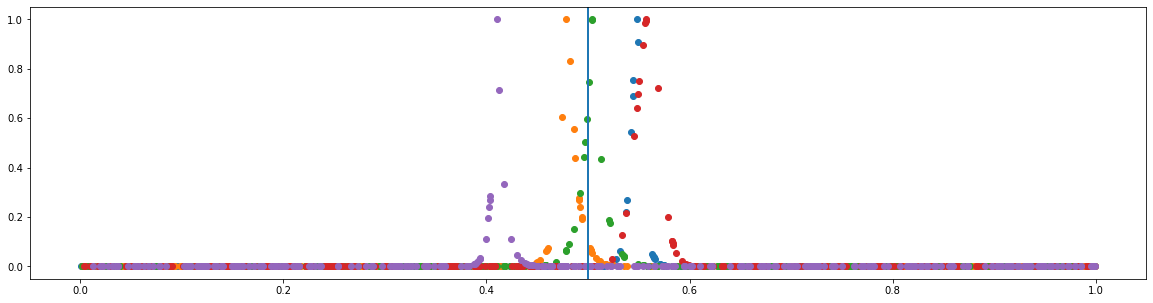

In [67]:
# Plot posteriors

plt.figure(figsize=(20, 5))
for i in range(NDIM):
    zp = post[i]['z']
    lnLp = np.exp(post[i]['lnL'])
    plt.axvline(z0[i])
    plt.scatter(zp, lnLp)
#plt.ylim([-10, 0])

In [114]:
z2_cpu = swyft.iter_sample_z(NSAMPLES, NDIM, net, x0, device = DEVICE, threshold = 1e-10)
xz2_cpu = swyft.simulate_xz(model, z2_cpu)

100%|██████████| 3000/3000 [00:03<00:00, 932.27it/s]


In [115]:
# Move training data to GPU
xz2 = []
for entry in tqdm(xz2_cpu):
    ex = entry['x'].to(DEVICE)
    ez = entry['z'].to(DEVICE)
    xz2.append(dict(x = ex, z = ez))
z2 = swyft.get_z(xz2)

100%|██████████| 3000/3000 [00:00<00:00, 12544.76it/s]


In [116]:
# Instantiate network

net2 = swyft.Network(xdim = ydim, zdim = NDIM, head = Head().cuda()).to(DEVICE).train()
loss  = swyft.train(net2, xz2, n_train = NTRAIN, lr = 1e-3, n_batch = NBATCH)
loss += swyft.train(net2, xz2, n_train = NTRAIN, lr = 1e-4, n_batch = NBATCH)
loss += swyft.train(net2, xz2, n_train = NTRAIN, lr = 1e-5, n_batch = NBATCH)

100%|██████████| 1000/1000 [00:26<00:00, 37.65it/s]


estimating lnL: 100%|██████████| 47/47 [00:00<00:00, 287.99it/s]


(0.0, 1.0)

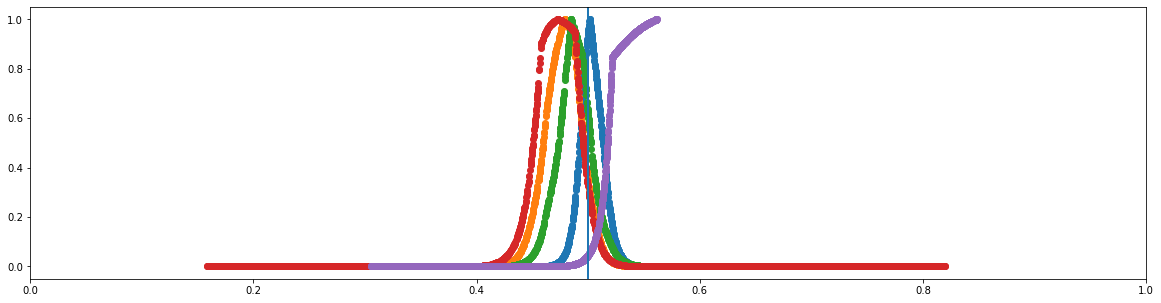

In [117]:
post2 = swyft.estimate_lnL(net2, x0, z2, device = 'cuda:0')
plt.figure(figsize=(20, 5))
for i in range(NDIM):
    zp = post2[i]['z']
    lnLp = np.exp(post2[i]['lnL'])
    plt.axvline(z0[i])
    plt.scatter(zp, lnLp)
plt.xlim([0, 1])

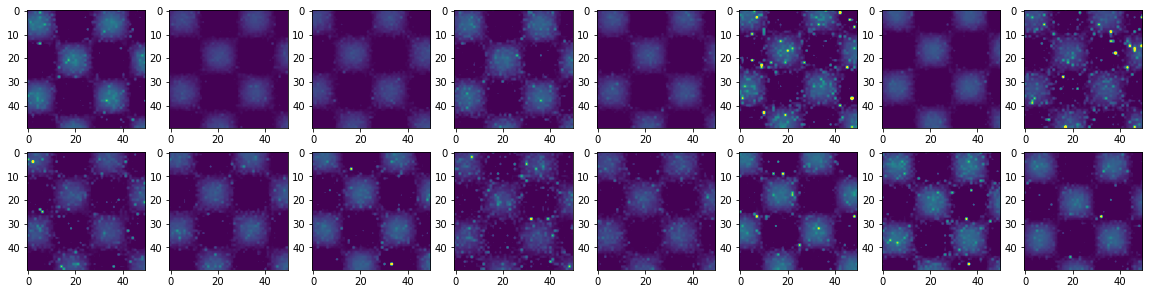

In [120]:
plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 8, i+1)
    z0 = z2[i].cpu()
    x0 = model(z0)
    plt.imshow(x0.numpy(), vmin = 0, vmax = 10)